출처: https://www.kaggle.com/code/arthurtok/interactive-porto-insights-a-plot-ly-tutorial/notebook

# Introduction

1. Data Quality Checks
2. Feature inspection and filtering
3. Feature imporatnce ranking via learning models

-----------------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings("ignore")

데이터 로드하기

In [2]:
train = pd.read_csv("./porto_seguro/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
rows, columns = train.shape[0], train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


-----

# 1. Data Quality checks

**Null or missing values check**

In [4]:
train.isnull().any().any()

False

- null 값의 유무를 체크하면 False로 나오지만 데이터의 설명처럼 null 값은 -1로 표현되어 있습니다.

이제 어떤 칼럼에 모든 -1을 null 값으로 바꿔봅시다.

In [5]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

이제 null 값을 시각화하는데 유용한 Missingno라는 패키지를 사용하겠습니다.

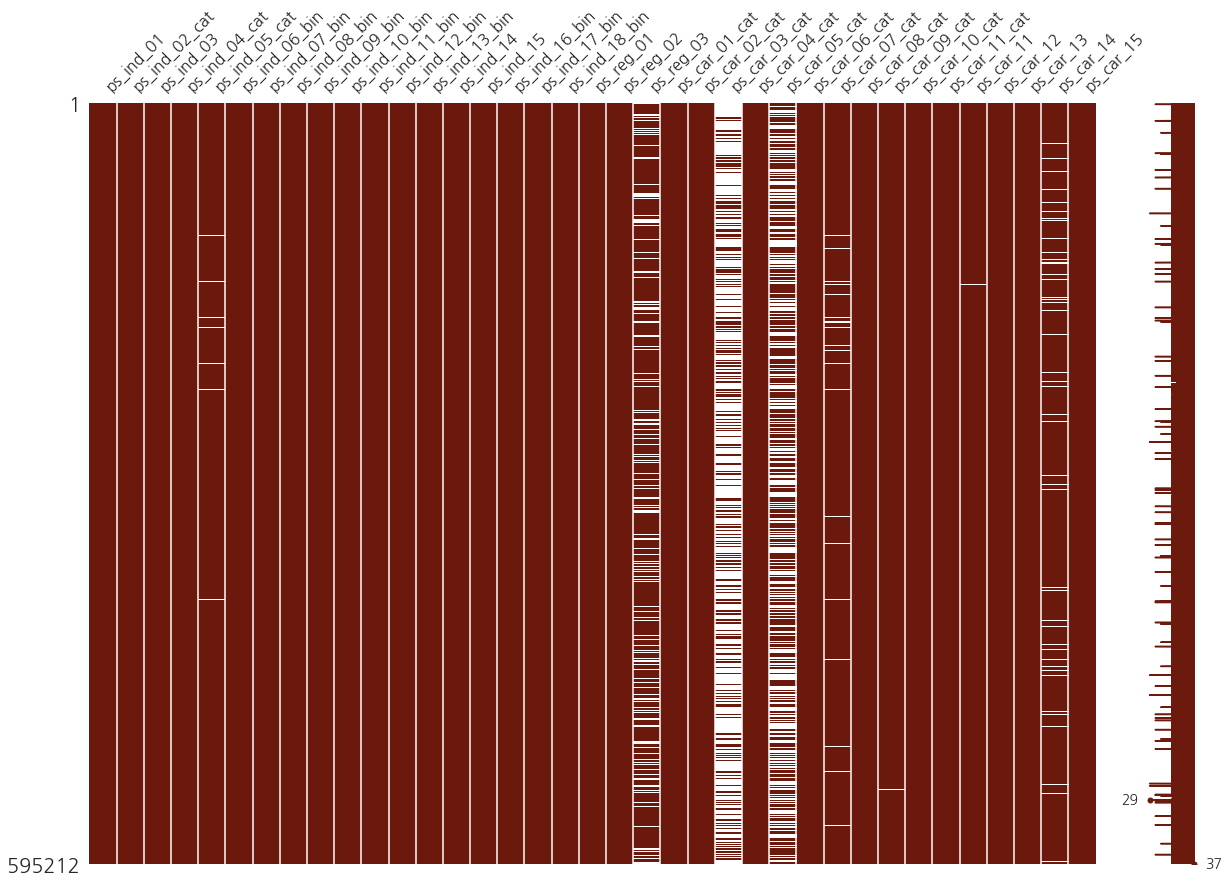

In [6]:
import missingno as msno

msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

수직의 갈색 밴드에 겹쳐 놓은 흰색 밴드는 각각의 칼럼의 null 값을 반영합니다. 

그리고 흰색의 비율에서 알 수 있듯이 3캐의 칼럼(ps_reg_03, ps_car_03_cat, ps_car_05_cat)은 null 값의 비율이 굉장히 높습니다. 따라서 이 세개의 칼럼에서는 -1을 null 값으로 바꾸는 것은 좋은 선택 같아 보이지 않습니다.

**Target variable inspection**

In [7]:
data = [go.Bar(
    x=train["target"].value_counts().index.values,
    y=train["target"].value_counts().values,
    text="Distribution of target variable"
)]

layout = go.Layout(title="Target variable distribution")

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename="basic-bar")

target 값의 분포가 매우 불균형한 모습

**Datatype check**

In [8]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [9]:
train_float = train.select_dtypes(include=["float64"])
train_int = train.select_dtypes(include=["int64"])

## Correlation plots

**Correlation of float features**

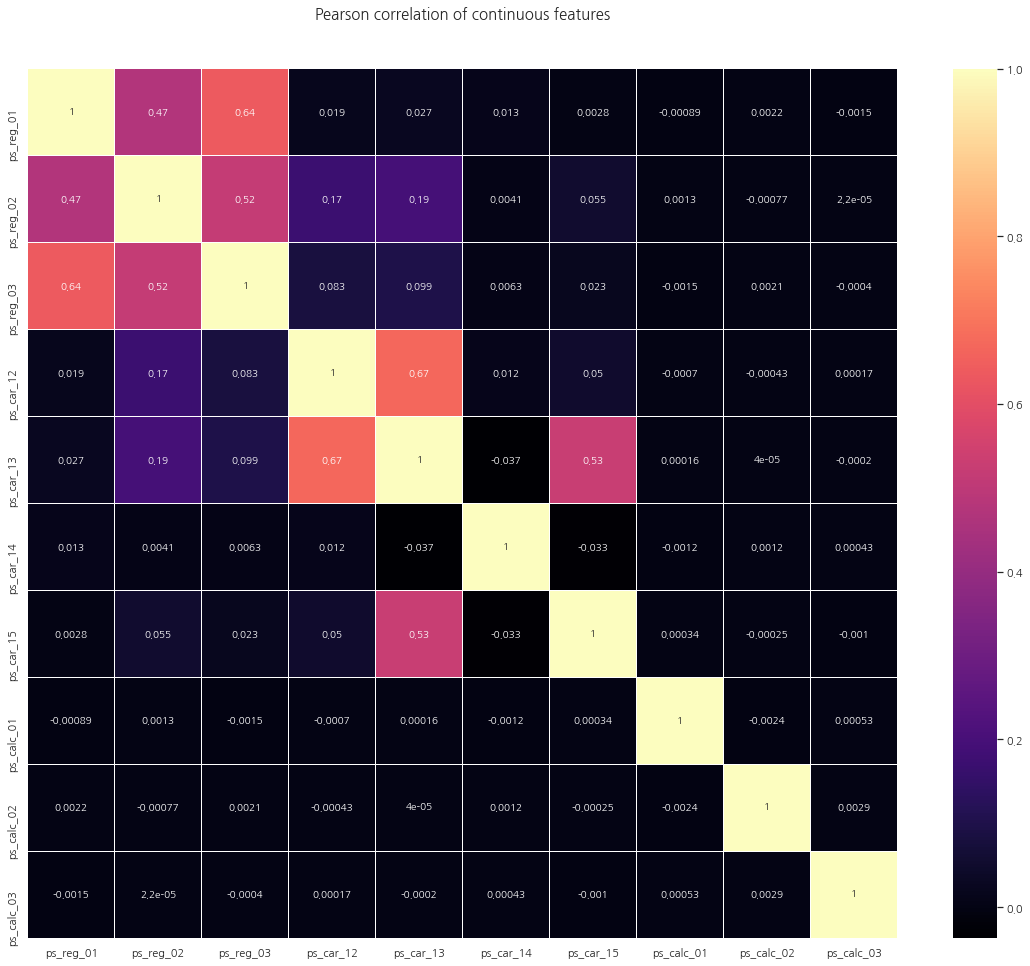

In [10]:
colormap = plt.cm.magma
plt.figure(figsize=(20, 16))
plt.title("Pearson correlation of continuous features", y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor="white", annot=True)

위의 heatmap에서 보듯이 상관관계가 거의 없거나 0인 많은 대다수의 칼럼을 볼 수 있습니다. 

그리고 다음 칼럼들은 양의 상관관계를 가지고 있습니다:

**(ps_reg_01, ps_reg_03)**

**(ps_reg_02, ps_reg_03)**

**(ps_car_12, ps_car_13)**

**(ps_car_13, ps_car_15)**

<br/>

**Correlation of integer features**

In [11]:
data = [
    go.Heatmap(
        x=train_int.columns.values,
        y=train_int.columns.values,
        z=train_int.corr().values,
        colorscale="Viridis",
        reversescale=False,
        opacity=1.0
    )
]

layout = go.Layout(
    title="Pearson Correlation of Integer-type features",
    xaxis=dict(ticks="", nticks=36),
    yaxis=dict(ticks=""),
    width=900, height=700
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="labelled-heatmap")

float 칼럼들과 마찬가지로 상당히 많은 상관관계가 0인 칼럼들이 관찰됩니다. 그리고 이러한 사실은 우리에게 유용한 정보를 줍니다. (PCA와 같은 차원축소는 어느정도의 상관관계가 필요하기 때문)

**음의 상관관계를 가지는 feature** : ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

또 한가지 흥미로운 점은 null 값이 많았던 ps_car_03_cat과 ps_car_05_cat은 서로 강한 양의 상관관계를 지닌다는 것입니다. (null 값이 많기 때문에 데이터의 진짜 의미를 반영하지 못했을 수도 있습니다)

## Mutual Information plots

**상호정보량(mutual information)**은 결합확률밀도함수 $p(x,y)$와 주변확률밀도함수의 곱 $p(x)p(y)$의 쿨벡-라이블러 발산이다. 

- Kullback–Leibler divergence(KLD), 쿨벡-라이블러 발산은 두 확률분포가 얼마나 다른지를 정량적으로 나타내는 수치다. 두 확률분포가 같으면 쿨벡-라이블러 발산은 0이 되고 다르면 다를수록 큰 값을 가진다 \begin{align}
KL(p||q) = \sum_{i=1}^{K} p(y_i) \log_2 \left(\dfrac{p(y_i)}{q(y_i)}\right)
\end{align}

즉 결합확률밀도함수와 주변확률밀도함수의 차이를 측정하므로써 두 확률변수의 상관관계를 측정하는 방법이다. 만약 두 확률변수가 독립이면 결합확률밀도함수는 주변확률밀도함수의 곱과 같으므로 상호정보량은 0이 된다. 반대로 상관관계가 있다면 그만큼 양의 상호정보량을 가진다.
\begin{align}
MI[X,Y] = KL\big(p(x,y)||p(x)p(y)\big)
= \sum_{i=1}^{K} p(x_i,y_i) \log_2 \left(\dfrac{p(x_i,y_i)}{p(x_i)p(y_i)}\right)
\end{align}

In [12]:
# classification 문제의 경우 mutual_info_classif 메서드를 통해 간단하게 의존성을 확일할 수 있다.
# 이를 통해 target의 정보가 얼마나 많이 feature에 담겨 있는지 확인할 수 있습니다.
# sklearn에서의 mutual_info_classif 메서드는 knn에 기반합니다.
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3,
                         random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


In [13]:
mf = mutual_info_classif(train_int.values, train.target.values, n_neighbors=3,
                         random_state=17)
print(mf)

[1.17324892e-04 1.56675651e-01 1.38264284e-02 6.33430140e-02
 1.20309373e-02 2.38432030e-02 2.24765319e-03 2.25035654e-02
 9.11565941e-03 3.59334853e-03 4.86660151e-03 4.69728845e-04
 0.00000000e+00 0.00000000e+00 1.06237611e-05 1.16722719e-04
 1.12730906e-02 6.07922851e-02 2.43079030e-03 3.03500473e-03
 3.25141482e-02 9.46913756e-02 7.12840168e-02 4.18227160e-03
 3.96651850e-02 1.60587450e-02 1.17697679e-01 9.46544656e-02
 7.32462040e-02 1.32479615e-01 6.13151667e-03 5.78371607e-02
 3.17179532e-02 2.99441464e-02 2.89148620e-02 2.48357519e-02
 2.83918103e-02 2.77323698e-02 1.22966851e-02 1.51276513e-02
 2.67392155e-02 2.02287109e-02 1.27108353e-02 1.74897783e-03
 5.41632945e-02 4.23397318e-02 1.11210288e-02 1.64724962e-02
 3.22373254e-03]


## Binary features inspection

In [15]:
bin_col = [col for col in train.columns if "_bin" in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col] == 0).sum())
    one_list.append((train[col] == 1).sum())

In [17]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list,
    name="Zero count"
)

trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name="One count"
)

data = [trace1, trace2]
layout = go.Layout(
    barmode="stack",
    title="Count of 1 and - in binary variables"
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="stacked-bar")

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin 칼럼들은 0의 값이 대부분입니다. 위의 칼럼들은 target을 예측하는데 유용한지에 대한 질문을 던지게 합니다.

## Feature importance via Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4,
                            max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(["id", "target"], axis=1), train.target)
features = train.drop(["id", "target"], axis=1).columns.values

**Plot.ly Scatter Plot of feature importances**

In [19]:
# Scatter plot
trace = go.Scatter(
    y=rf.feature_importances_,
    x=features,
    mode="markers",
    marker=dict(
        sizemode="diameter",
        sizeref=1,
        size=13,
        color=rf.feature_importances_,
        colorscale="Portland",
        showscale=True
    ),
    text=features
)

data = [trace]

layout = go.Layout(
    autosize=True,
    title="Random Forest Feature Importance",
    hovermode="closest",
    xaxis=dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title="Feature Importance",
        showgrid=False,
        zeroline=False,
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

In [21]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),
                                      reverse=False)))

# Barplot
trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale="Viridis",
        reversescale=True
    ),
    name="Random Forest Feature importance",
    orientation="h"
)

layout = dict(
    title="Barplot of Feature importances",
    width=900, height=2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)

fig1 = go.Figure(data=[trace2])
fig1["layout"].update(layout)
py.iplot(fig1, filename="plots")

**Decision Tree visualisation**

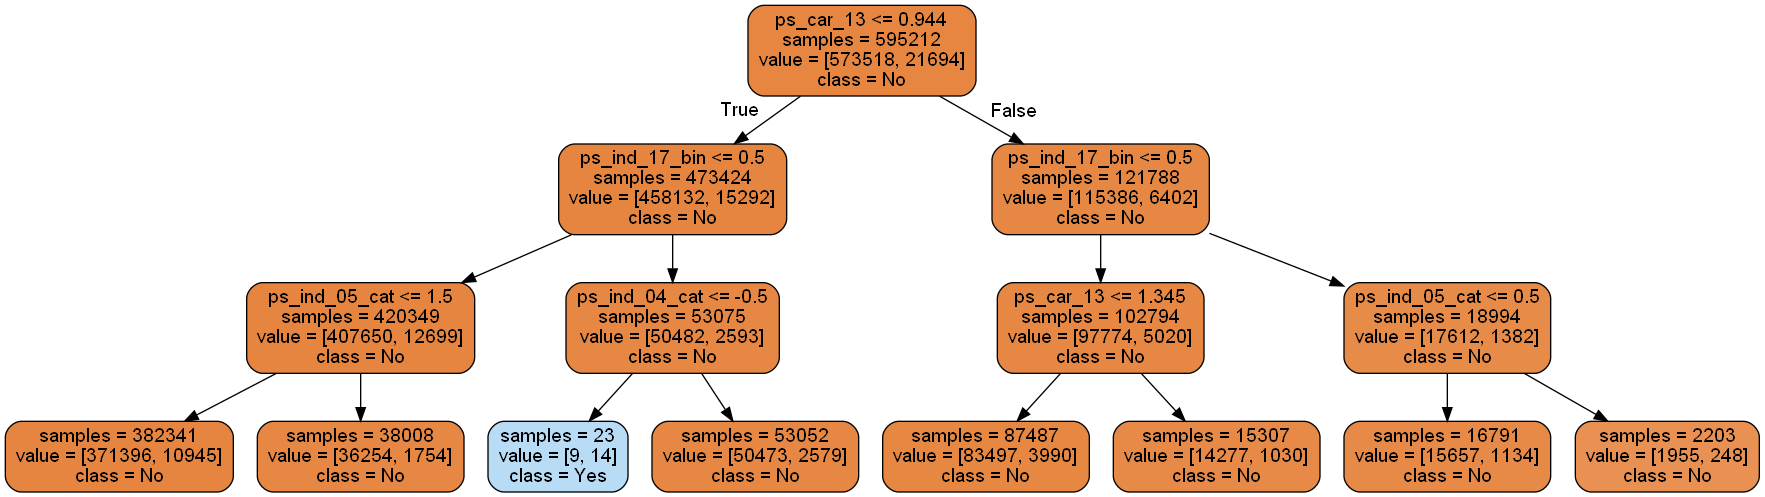

In [23]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(["id", "target"], axis=1), train.target)

# 훈련된 모델을 .dot 파일로 내보내기
with open("tree1.dot", "w") as f:
    f = tree.export_graphviz(decision_tree, out_file=f, max_depth=4,
                             impurity=False,
                             feature_names=train.drop(["id", "target"], axis=1).columns.values,
                             class_names=["No", "Yes"],
                             rounded=True,
                             filled=True)
    
    
# jupyter notebook에 표시할 수 있도록 .dot를 .png로 변환
check_call(["dot", "-Tpng", "tree1.dot", "-o", "tree1.png"])

# PIL 라이브러리로 시각화
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save("sample-out.png")
PImage("sample-out.png")

## Feature importance via Gradient Boosting model

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4,
                                max_features=0.2, random_state=0)
gb.fit(train.drop(["id", "target"], axis=1), train.target)
features = train.drop(["id", "target"], axis=1).columns.values

In [26]:
# Scatter plot
trace = go.Scatter(
    y=gb.feature_importances_,
    x=features,
    mode="markers",
    marker=dict(
        sizemode="diameter",
        sizeref=1,
        size=13,
        color=gb.feature_importances_,
        colorscale="Portland",
        showscale=True
    ),
    text=features
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title="Gradient Boosting Machine Feature Importance",
    hovermode="closest",
    xaxis=dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title="Feature Importance",
        showgrid=False,
        zeroline=False,
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

In [31]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))

trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale="Viridis",
        reversescale=True
    ),
    name="Gradient Boosting Classifier Feature importance",
    orientation="h"
)

layout = dict(
    title="Barplot of Feature importances",
    width=900, height=2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)

fig1 = go.Figure(data=[trace2])
fig1["layout"].update(layout)
py.iplot(fig1, filename="plots")

Random Forest와 Gradient Boosting 모델에서 가장 중요한 칼럼은 **ps_car_13**

--------------
# Conclusion

null 값과 데이터를 점검하여 Porto Seguro 데이터 세트에 대해 상당히 광범위한 검사를 수행하고, feature 간의 선형 상관 관계를 조사하고, 일부 feature 분포를 검사하고 몇 가지 학습 모델(Random Forest, Gradient Boosting)을 구현했습니다. (모델이 중요하다고 생각하는 feature을 식별하기 위해)